In [1]:
import pandas as pd
import numpy as np
import graph_tool.all as gt
from sklearn.preprocessing import LabelEncoder
import matplotlib
import graph_tool.topology as gtt
from tqdm.autonotebook import tqdm
import itertools
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
data = "2009"

/scratch/slurm_tmpdir/job_24545020/ipykernel_442307/588787847.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## strain taxonomy

In [2]:
# tax = pd.read_csv("https://gg-sg-web.s3-us-west-2.amazonaws.com/downloads/strainselect_database/StrainSelect21/StrainSelect21_taxonomy_translator_for_236992_strains.tab.txt",sep = "\t")

In [3]:
# vertices = pd.read_csv("https://gg-sg-web.s3-us-west-2.amazonaws.com/downloads/strainselect_database/StrainSelect21/StrainSelect21_vertices.tab.txt",sep="\t")

In [4]:
vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt", sep="\t")

/scratch/slurm_tmpdir/job_24545020/ipykernel_442307/3051067415.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt", sep="\t")


In [5]:
def getstrain(strainselectid):
    filtered_vertices = vertices[vertices.StrainSelectID == strainselectid]
    gss_vertices = filtered_vertices[filtered_vertices["vertex_type"] == "gss"]
    if not gss_vertices.empty:
        shortest_strain = min(gss_vertices.iloc[:, 0], key=lambda x: len(str(x)))
        shortest_strain = shortest_strain.replace("."," ").capitalize()
        return shortest_strain
    return None  # Return None if no matching strain is found

# Graph-tool

In [6]:
df = pd.read_csv(f"../../preds{data}/network.tsv", sep="\t")

In [7]:
df

,source,target,rel,source_ner,target_ner
0,t__597668,forest soil,INHABITS,STRAIN,ISOLATE
1,t__183280,diseased crucian carp,INHABITS,STRAIN,ISOLATE
2,t__91849,intensive care unit,INHABITS,STRAIN,ISOLATE
3,t__100077,human,INHABITS,STRAIN,ISOLATE
4,t__301566,tobacco,INHABITS,STRAIN,ISOLATE
...,...,...,...,...,...
434658,t__180276,e. coli,INHIBITS,STRAIN,SPECIES
434659,t__180276,c. albicans,INHIBITS,STRAIN,SPECIES
434660,t__550308,s.,INHIBITS,STRAIN,SPECIES
434661,t__521667,e. amylovora,INHIBITS,STRAIN,SPECIES


In [8]:
df_filtered = df[(df["source"] != "t__415428") | (df["target"] != "t__415428")]
df_filtered.to_csv("network_files/network_filtered.tsv", sep="\t", index=False)

In [9]:
with open(f"../../preds{data}/strains.txt","r") as f:
	st = f.read().splitlines()

In [10]:
#g = gt.load_graph_from_csv(f"../../preds{data}/network.tsv", directed=True, csv_options={"delimiter": "\t"})
g = gt.load_graph_from_csv(f"network_files/network_filtered.tsv", directed=True, csv_options={"delimiter": "\t"})

In [11]:
g

<Graph object, directed, with 181329 vertices and 434664 edges, 1 internal vertex property, 3 internal edge properties, at 0x1504a31513d0>

In [12]:
rel = g.new_edge_property("int64_t")
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c0"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [13]:
# get the top 10 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:30]

# print the top 10 nodes by indegree with their names
print("Top 10 nodes by indegree:")
for node, degree in top5_indegree:
    if g.vp["name"][node].startswith("t__"):
        print(getstrain(g.vp["name"][node]),"\t",degree)
    else:
    	print(g.vp["name"][node],"\t", degree)

Top 10 nodes by indegree:
lb 	 2556
biofilm 	 2447
gram negative 	 2142
soil 	 2017
gram positive 	 1981
human 	 1906
mouse 	 1784
probiotic 	 1759
lb broth 	 1305
tsb 	 1250
eps 	 1044
siderophore 	 1013
biofilm formation 	 1002
iaa 	 972
marine 	 935
Escherichia coli eli 51 	 919
bhi 	 883
Staphylococcus aureus lmg 	 868
endophytic 	 825
tetracycline 	 779
mrs 	 696
lb agar 	 673
biocontrol 	 660
nb 	 648
mrs broth 	 645
bhi broth 	 635
Staphylococcus aureus wichita 	 618
rod shaped 	 600
tomato 	 596
Pseudomonas aeruginosa 1c 	 591


In [14]:
# get the top 10 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:30]

# print the top 10 nodes by outdegree with their names
print("Top 10 nodes by outdegree:")
for node, degree in top5_outdegree:
    original_name = g.vp["name"][node]
    print(f"{original_name}\t{getstrain(original_name)}\t{degree}")

Top 10 nodes by outdegree:
t__12278	Lactobacillus lmg 17291	3289
t__468063	Escherichia coli o157 h7	3096
t__58098	Pseudomonas aeruginosa 1c	2074
t__31174	Escherichia coli bl21	1474
t__480700	Escherichia coli bl21de3	1454
t__61831	Pseudomonas putida kt2440	1302
t__30867	Escherichia coli mg1655	1262
t__66540	Escherichia coli eli 51	1223
t__10737	Escherichia coli k 12	1206
t__94811	Escherichia coli nissle 1917	1061
t__12751	Bacillus sp dsm 10	1038
t__31928	Staphylococcus aureus lmg	967
t__447400	Escherichia coli o157	905
t__221782	Salmonella enterica acm 5063	900
t__132830	Lactobacillus plantarum 1	867
t__164989	Pseudomonas aeruginosa rw1	804
t__128732	Escherichia coli op50	728
t__366291	Pseudomonas syringae p5	721
t__30818	Escherichia coli cft073	700
t__57630	Burkholderia phytofirmans psjn	678
t__26471	Fachb 805 pcc 7942	677
t__31906	Staphylococcus aureus wichita	637
t__48542	Pseudomonas aeruginosa acm 5201	634
t__79308	Bacillus sp kacc 18228	587
t__68697	Shewanella oneidenses mr 1	585
t

In [15]:
# # create a vertex property map to store the color and size of each vertex
# vertex_color = g.new_vertex_property("vector<double>")
# vertex_size = g.new_vertex_property("double")

# # set the color and size of vertices in st list to red and others to blue
# for v in g.vertices():
# 	if g.vp["name"][v] in st:
# 		vertex_color[v] = [0, 0, 1, 0.5]  # red with transparency
# 	else:
# 		vertex_color[v] = [1, 0, 0, 0.5]  # blue with transparency
# 	vertex_size[v] = 2 

# # draw the graph with the vertex colors and sizes
# pos = gt.sfdp_layout(g, coarse_method="hybrid", mu=3, gamma=.5, C=1e-5)
# gt.graph_draw(g, pos=pos, edge_color=rel, vertex_fill_color=vertex_color, vertex_size=vertex_size, output_size=(800, 800))


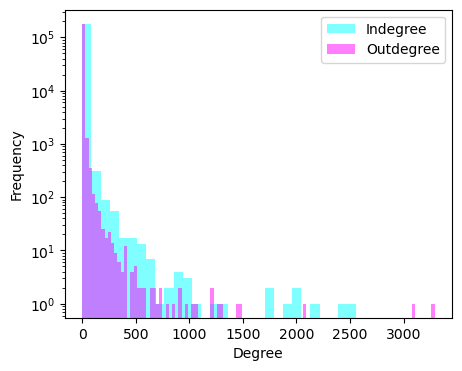

In [16]:
# set the dark background style
# plt.style.use('dark_background')

# create a new figure with the desired size
plt.figure(figsize=(5, 4))

# get the indegree and outdegree of all vertices
in_degrees = g.get_in_degrees(g.get_vertices())
out_degrees = g.get_out_degrees(g.get_vertices())

# plot the histogram of indegree
plt.hist(in_degrees, bins=30, alpha=0.5, color='cyan', label='Indegree')

# plot the histogram of outdegree
plt.hist(out_degrees, bins=110, alpha=0.5, color='magenta', label='Outdegree')

# add labels and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')

# show the plot
plt.savefig("network_files/degree_distribution_hist.png", dpi=600, bbox_inches='tight')


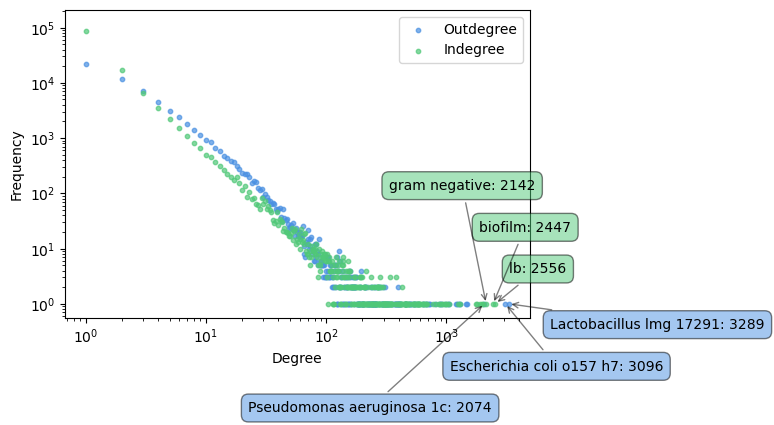

In [17]:
# create a new figure with the desired size
plt.figure(figsize=(6, 4))

# get the indegree and outdegree of all vertices
in_degrees = g.get_in_degrees(g.get_vertices()).astype(np.int64)
out_degrees = g.get_out_degrees(g.get_vertices()).astype(np.int64)

# calculate the frequency of each degree
in_degree_freq = np.bincount(in_degrees)
out_degree_freq = np.bincount(out_degrees)

# define colors
outdegree_color = '#4a90e2'
indegree_color = '#50c878'

# plot the scatter plot of degree frequency
plt.scatter(range(len(out_degree_freq)), out_degree_freq, color=outdegree_color, label='Outdegree', alpha=0.7, s=10)
plt.scatter(range(len(in_degree_freq)), in_degree_freq, color=indegree_color, label='Indegree', alpha=0.7, s=10)

# get top 3 nodes for indegree and outdegree
top_in_degrees = sorted([(v, d) for v, d in enumerate(in_degrees)], key=lambda x: x[1], reverse=True)[:3]
top_out_degrees = sorted([(v, d) for v, d in enumerate(out_degrees)], key=lambda x: x[1], reverse=True)[:3]

# Define custom positions for each label
in_degree_positions = [(10, 20), (-10, 50), (-70, 80)]
out_degree_positions = [(30, -10), (-40, -40), (-170, -70)]

# label top 3 nodes for indegree and outdegree
for i, ((v, d), position) in enumerate(zip(top_in_degrees, in_degree_positions)):
    plt.annotate(f"{g.vp['name'][v]}: {d}", (d, in_degree_freq[d]), xytext=position, 
                 textcoords='offset points', ha='left', va='bottom', 
                 bbox=dict(boxstyle='round,pad=0.5', fc=indegree_color, alpha=0.5),
                 arrowprops=dict(arrowstyle='->', alpha=.5, connectionstyle='arc3,rad=0'))

for i, ((v, d), position) in enumerate(zip(top_out_degrees, out_degree_positions)):
    plt.annotate(f"{getstrain(g.vp['name'][v])}: {d}", (d, out_degree_freq[d]), xytext=position, 
                 textcoords='offset points', ha='left', va='top', 
                 bbox=dict(boxstyle='round,pad=0.5', fc=outdegree_color, alpha=0.5),
                 arrowprops=dict(arrowstyle='->', alpha=.5, connectionstyle='arc3,rad=0'))

# add labels and legend
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.yscale('log')
plt.xscale('log')

# save the plot as PNG and PDF
plt.savefig("network_files/degree_distribution_scatter.png", dpi=600, bbox_inches='tight')
plt.savefig("network_files/degree_distribution_scatter.pdf", bbox_inches='tight')

In [18]:
# create a vertex property map to store the color of each vertex
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

In [19]:
# # create a filtered graph with nodes and edges that have indegree or outdegree greater than 1
# filtered_g = gt.GraphView(g, vfilt=lambda v: v.in_degree() > 1 or v.out_degree() > 1)

# # draw the filtered graph with the vertex colors
# pos = gt.sfdp_layout(filtered_g)
# gt.graph_draw(filtered_g, pos=pos, vertex_fill_color=vertex_color, output_size=(2000, 2000))


In [20]:
# # create a filtered graph with nodes and edges that point to the "soil" node
# filtered_g = gt.GraphView(g, efilt=lambda e: e.target() == g.vertex(3))

# # draw the filtered graph
# pos = gt.sfdp_layout(filtered_g)
# gt.graph_draw(filtered_g, pos=pos, vertex_fill_color=vertex_color, output_size=(2000, 2000))

In [21]:
# # create a vertex property map to store the color of each vertex
# vertex_color = g.new_vertex_property("vector<double>")

# # set the color of source vertices to red and target vertices to blue
# for v in g.vertices():
# 	if v.in_degree() == 0:
# 		vertex_color[v] = [1, 0, 0, .8]  # red
# 	elif v.out_degree() == 0:
# 		vertex_color[v] = [0, 0, 1, .8]  # blue
# 	else:
# 		vertex_color[v] = [0, 0, 0, .8]  # black

# # draw the graph with the vertex colors
# pos = gt.sfdp_layout(g)
# gt.graph_draw(g, pos=pos, vertex_fill_color=vertex_color, output_size=(800, 800))


In [22]:
# gt.graph_draw(g, gt.sfdp_layout(g), edge_color=rel,vertex_fill_color=vertex_color, output_size=(2500,2500),ink_scale= .6,inline=True, vertex_size=8, output="network_files/network1000.png")

In [23]:
num_vertices = g.num_vertices()
num_edges = g.num_edges()
print("Number of vertices:", num_vertices)
print("Number of edges:", num_edges)

Number of vertices: 181329
Number of edges: 434664


In [24]:
g.set_directed(False)
# Extract the largest component
largest_comp = gt.GraphView(g, vfilt = gt.label_largest_component(g))
largest_comp.set_directed(True)

In [25]:
# # Draw the largest component
# gt.graph_draw(largest_comp, gt.sfdp_layout(largest_comp, p=1.3), edge_color=rel,vertex_fill_color=vertex_color, output_size=(1000,1000),ink_scale= .3,inline=True, vertex_size=5,output="network_files/network1000mc.png")

In [26]:
num_vertices = largest_comp.num_vertices()
num_edges = largest_comp.num_edges()
print("Number of vertices of the largest component:", num_vertices)
print("Number of edges of the largest component:", num_edges)

Number of vertices of the largest component: 171996
Number of edges of the largest component: 428940


In [27]:
g.set_directed(True)

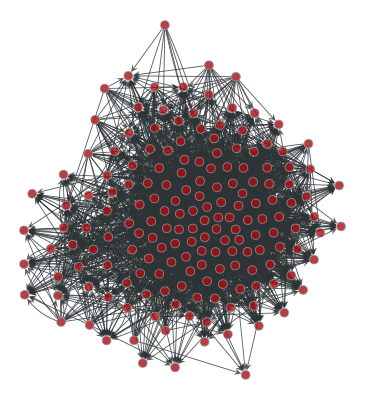

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1504a1dd07d0, at 0x1504a19a97c0>

In [28]:
# create a filtered graph with vertices that have a degree of at least 10
filtered_g = gt.GraphView(g, vfilt=lambda v: v.out_degree() + v.in_degree() >= 300)

# draw the filtered graph
pos = gt.sfdp_layout(filtered_g)
gt.graph_draw(filtered_g, pos=pos, output_size=(200, 200))


### Get other metrics

In [29]:
vb, eb = gt.betweenness(g)

In [30]:
# Get the top 10 vertices with the highest betweenness centrality
top_vertices = sorted(g.vertices(), key=lambda v: vb[v], reverse=True)[:10]

# Show the nodes of the top 10 vertices
print("\nNodes of the top 10 vertices:")
for v in top_vertices:
    node_name = g.vp['name'][v]
    if node_name.startswith("t__"):
        strain_info = getstrain(node_name)
        print(f"Node {int(v)}: {strain_info} (Score: {vb[v]})")
    else:
        print(f"Node {int(v)}: {node_name} (Score: {vb[v]})")
    
# Get the top 10 edges with the highest betweenness centrality
top_edges = sorted(g.edges(), key=lambda e: eb[e], reverse=True)[:10]

# Show the top 10 edges
print("\nTop 10 edges with the highest betweenness centrality:")
for e in top_edges:
    source_name = g.vp['name'][e.source()]
    target_name = g.vp['name'][e.target()]
    if source_name.startswith("t__"):
        source_name = getstrain(source_name)
    if target_name.startswith("t__"):
        target_name = getstrain(target_name)
    print(f"Edge ({int(e.source())}, {int(e.target())}) [{source_name} -> {target_name}]: {eb[e]}")


Nodes of the top 10 vertices:
Node 40: Escherichia coli o157 h7 (Score: 0.005936909199623887)
Node 626: Pseudomonas aeruginosa 1c (Score: 0.005677698842452505)
Node 99: Escherichia coli eli 51 (Score: 0.005112207740496286)
Node 648: Staphylococcus aureus lmg (Score: 0.0040997017717309975)
Node 74938: ampicillin (Score: 0.002882582230335358)
Node 74780: colistin (Score: 0.0028390331188074126)
Node 50: Lactobacillus lmg 17291 (Score: 0.0025877133223743153)
Node 75213: kanamycin (Score: 0.0023561960818229096)
Node 92452: rifampicin (Score: 0.0022830506841428335)
Node 61129: eps (Score: 0.0022603598208607617)

Top 10 edges with the highest betweenness centrality:
Edge (116818, 74780) [Enterobacter cloacae fl 1283 -> colistin]: 0.0016434734625660112
Edge (14467, 116818) [lb -> Enterobacter cloacae fl 1283]: 0.0016428312793542736
Edge (61129, 50) [eps -> Lactobacillus lmg 17291]: 0.0007279846798559421
Edge (83823, 626) [siderophore -> Pseudomonas aeruginosa 1c]: 0.0004829567548402273
Edge (

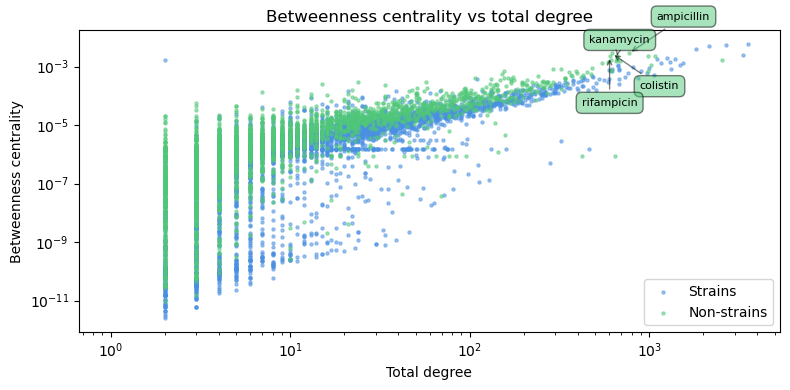

In [31]:
import matplotlib.pyplot as plt

# Calculate total degree and betweenness centrality for all vertices
total_degrees = [v.in_degree() + v.out_degree() for v in g.vertices()]
bc_values = [vb[v] for v in g.vertices()]

# Separate strains and non-strains
strain_degrees = []
strain_bc = []
non_strain_degrees = []
non_strain_bc = []

for v in g.vertices():
    if g.vp['name'][v].startswith("t__"):
        strain_degrees.append(v.in_degree() + v.out_degree())
        strain_bc.append(vb[v])
    else:
        non_strain_degrees.append(v.in_degree() + v.out_degree())
        non_strain_bc.append(vb[v])

# Create the plot
plt.figure(figsize=(8, 4))
plt.scatter(strain_degrees, strain_bc, color=outdegree_color, s=5, alpha=0.5, label='Strains')
plt.scatter(non_strain_degrees, non_strain_bc, color=indegree_color, s=5, alpha=0.5, label='Non-strains')
plt.xlabel('Total degree')
plt.ylabel('Betweenness centrality')
plt.title('Betweenness centrality vs total degree')
plt.xscale('log')  # Use log scale for x-axis due to potentially large differences
plt.yscale('log')  # Use log scale for y-axis due to potentially large differences
plt.legend()

# Label only the non-strain nodes in the top 10 by betweenness centrality
top_10_vertices = sorted(g.vertices(), key=lambda v: vb[v], reverse=True)[:10]
non_strain_top_10 = [v for v in top_10_vertices if not g.vp['name'][v].startswith("t__")]
positions = [(20, 30), (20, -20), (-20, 15), (-20, -30)]

for (v, position) in zip(non_strain_top_10, positions):
    node_name = g.vp['name'][v]
    plt.annotate(f"{node_name}", 
                 (v.in_degree() + v.out_degree(), vb[v]),
                 xytext=position, 
                 textcoords='offset points',
                 ha='left', 
                 va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc=indegree_color, alpha=0.5),
                 arrowprops=dict(arrowstyle='->', alpha=.5, connectionstyle='arc3,rad=0'),
                 fontsize=8,
                 color="k")

plt.tight_layout()

# Save as PNG
plt.savefig('network_files/betweenness_centrality_vs_total_degree.png', dpi=600, bbox_inches='tight')
# Save as PDF
plt.savefig('network_files/betweenness_centrality_vs_total_degree.pdf', bbox_inches='tight')


In [32]:
# Calculate Jaccard edge similarity for nodes with degree >= 100
high_degree_vertices = [v for v in g.vertices() if v.in_degree() + v.out_degree() >= 50]

# Calculate Jaccard similarity for these vertices
jaccard_similarity = gt.vertex_similarity(g, "jaccard", vertex_pairs=list(itertools.combinations(high_degree_vertices, 2)))

# Create a list of (vertex1, vertex2, jaccard_coefficient) tuples, excluding NaN values
jaccard_edges = [(high_degree_vertices[i], high_degree_vertices[j], jaccard_similarity[k]) 
                 for k, (i, j) in enumerate(itertools.combinations(range(len(high_degree_vertices)), 2))
                 if not np.isnan(jaccard_similarity[k])]

# Sort the edges by Jaccard coefficient in descending order
jaccard_edges.sort(key=lambda x: x[2], reverse=True)

# Display the top 20 edges with highest Jaccard similarity
print("Top 20 edges with highest Jaccard similarity:")
for i, (v1, v2, similarity) in enumerate(jaccard_edges[:20], 1):
    source_name = g.vp['name'][v1]
    target_name = g.vp['name'][v2]
    if source_name.startswith("t__"):
        source_name = getstrain(source_name)
    if target_name.startswith("t__"):
        target_name = getstrain(target_name)
    print(f"{i}. Edge ({int(v1)}, {int(v2)}) [{source_name} - {target_name}]: {similarity:.4f}")

# Display the top 20 edges with highest Jaccard similarity where both vertices start with "t__"
print("\nTop 20 edges with highest Jaccard similarity (both vertices start with 't__'):")
t_edges = [(v1, v2, similarity) for v1, v2, similarity in jaccard_edges if g.vp['name'][v1].startswith("t__") and g.vp['name'][v2].startswith("t__")]
for i, (v1, v2, similarity) in enumerate(t_edges[:20], 1):
    source_name = getstrain(g.vp['name'][v1])
    target_name = getstrain(g.vp['name'][v2])
    print(f"{i}. Edge ({int(v1)}, {int(v2)}) [{source_name} - {target_name}]: {similarity:.4f}")


Top 20 edges with highest Jaccard similarity:
1. Edge (5815, 59174) [cystic fibrosis - k]: 1.0000
2. Edge (47880, 115711) [pyrene - pahs]: 1.0000
3. Edge (61080, 122215) [fructose - gluconic acid]: 1.0000
4. Edge (61395, 66854) [pectin - n]: 1.0000
5. Edge (61395, 80669) [pectin - gelatin]: 1.0000
6. Edge (61395, 83078) [pectin - lactic]: 1.0000
7. Edge (66854, 80669) [n - gelatin]: 1.0000
8. Edge (66854, 83078) [n - lactic]: 1.0000
9. Edge (80669, 83078) [gelatin - lactic]: 1.0000
10. Edge (58972, 119063) [mb - lta]: 0.6667
11. Edge (589, 88949) [m - histamine]: 0.5000
12. Edge (5815, 40387) [cystic fibrosis - as]: 0.5000
13. Edge (5815, 117837) [cystic fibrosis - gsh]: 0.5000
14. Edge (19855, 58972) [uc - mb]: 0.5000
15. Edge (19855, 60713) [uc - pga]: 0.5000
16. Edge (19855, 67788) [uc - phb]: 0.5000
17. Edge (19855, 114964) [uc - acetone]: 0.5000
18. Edge (19855, 115904) [uc - camp]: 0.5000
19. Edge (22030, 61395) [pda - pectin]: 0.5000
20. Edge (22030, 66854) [pda - n]: 0.5000

To

/scratch/slurm_tmpdir/job_24545020/ipykernel_442307/3329561680.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


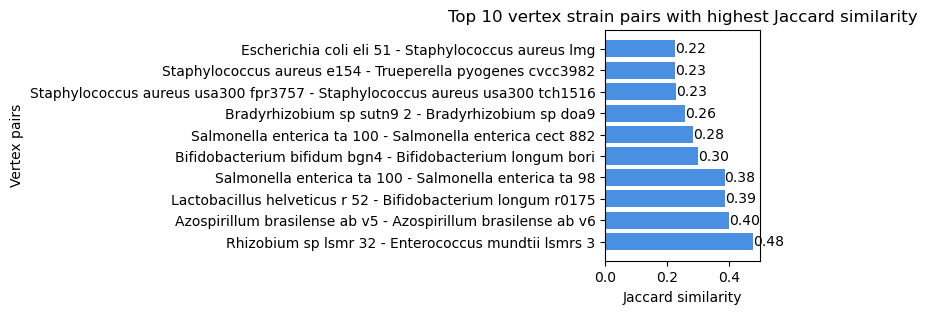

In [33]:
import matplotlib.pyplot as plt

# Get the top 10 edges with highest Jaccard similarity where both vertices start with "t__"
top_10_edges = [edge for edge in jaccard_edges if g.vp['name'][edge[0]].startswith("t__") and g.vp['name'][edge[1]].startswith("t__")][:10]

# Extract vertex names and similarity values
vertex_pairs = [f"{getstrain(g.vp['name'][v1])} - {getstrain(g.vp['name'][v2])}" for v1, v2, _ in top_10_edges]
similarities = [similarity for _, _, similarity in top_10_edges]

# Create the horizontal bar chart
plt.figure(figsize=(2, 3))
bars = plt.barh(range(len(vertex_pairs)), similarities, color=outdegree_color)
plt.ylabel('Vertex pairs')
plt.xlabel('Jaccard similarity')
plt.title('Top 10 vertex strain pairs with highest Jaccard similarity')
plt.yticks(range(len(vertex_pairs)), vertex_pairs)

# Add value labels to the right of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:.2f}',
             ha='left', va='center')

plt.tight_layout()

# Save as PNG
plt.savefig('network_files/top_10_jaccard_similarity_t_only.png', dpi=600, bbox_inches='tight')
# Save as PDF
plt.savefig('network_files/top_10_jaccard_similarity_t_only.pdf', bbox_inches='tight')

### nested blockmodel

In [ ]:
state = gt.minimize_nested_blockmodel_dl(largest_comp)

In [ ]:
len(set(state.levels[0].get_blocks()))

In [42]:
# gt.draw_hierarchy(state,output_size=(1500,1500))

---

### MEDIUM

In [43]:
file = "network_files/network_medium.csv"
df[df["target_ner"]=="MEDIUM"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [43]:
rel = g.new_edge_property("int64_t")
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [44]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
lb 	 2730
pbs 	 1297
tsb 	 1240
lb broth 	 1091
bhi 	 939
Top 5 nodes by outdegree:
escherichia.coli.bl21.de3 	 677
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 505
escherichia.coli.o157.h7 	 493
escherichia.coli.ncim.2931 	 468
escherichia.coli.k.12.c321.deltaa.m9adapted 	 432


In [23]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g, weighted_coarse=True)
gt.graph_draw(g, pos, edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True,output="network_files/strain.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x322d0ecc0, at 0x3278cecc0>

### PHENOTYPE

In [45]:
file = "network_files/network_phenotype.csv"
df[df["target_ner"]=="PHENOTYPE"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [46]:
rel = g.new_edge_property("int64_t")
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [47]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
biofilm 	 3378
probiotic 	 2154
gram- 	 2002
gram 	 1756
gram - negative 	 1631
Top 5 nodes by outdegree:
escherichia.coli.o157.h7 	 253
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 242
escherichia.coli.ncim.2931 	 196
bacillus.sp.dsm.10 	 185
escherichia.coli.k.12.5.1 	 172


In [27]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos, edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/phenotype.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3274f63f0, at 0x17fd39580>

### ISOLATE

In [48]:
file = "network_files/network_isolate.csv"
df[df["target_ner"]=="ISOLATE"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [49]:
rel = g.new_edge_property("int64_t")
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [50]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
patient 	 221
soil 	 212
year 	 123
hot spring 	 93
blood of 	 59
Top 5 nodes by outdegree:
escherichia.coli.o157.h7 	 40
lacticaseibacillus.paracasei.atcc.11974 	 36
escherichia.coli.o6.k2.h1.cft073 	 35
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 33
lacticaseibacillus.rhamnosus.bcrc.16000 	 19


In [41]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, pos, edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/isolate.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x3699ea270, at 0x3573f54c0>

### EFFECT

In [32]:
file = "network_files/network_effect.csv"
df[df["target_ner"] == "EFFECT"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [33]:
rel = g.new_edge_property("int64_t")
pos = gt.sfdp_layout(g)
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [34]:
# get the top 10 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top10_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:10]

# get the top 10 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top10_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:10]

# print the top 10 nodes by indegree and outdegree with their names
print("Top 10 nodes by indegree:")
for node, degree in top10_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 10 nodes by outdegree:")
for node, degree in top10_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 10 nodes by indegree:
antimicrobial 	 999
antibacterial 	 738
plant growth 	 708
of 	 671
antifungal 	 617
biofilm formation 	 553
biocontrol 	 436
- 	 360
production 	 356
% 	 353
Top 10 nodes by outdegree:
streptomyces.lavendulae.covid.911 	 4236
lacticaseibacillus.rhamnosus.bcrc.16000 	 3072
escherichia.coli.o157.h7 	 1062
escherichia.coli.nissle.1917 	 817
pseudomonas.putida.atcc.47054 	 706
lacticaseibacillus.rhamnosus.crl1505 	 650
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 632
shewanella.oneidenses.mr.1 	 622
burkholderia.phytofirmans.ccug.49060 	 616
pseudomonas.syringae.p5 	 556


In [35]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, gt.sfdp_layout(g), edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/effect.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x327801010, at 0x336c11c40>

### COMPOUND

In [29]:
file = "network_files/network_compound.csv"
df[(df["source_ner"]=="COMPOUND")|(df["target_ner"]=="COMPOUND")].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [30]:
rel = g.new_edge_property("int64_t")
pos = gt.sfdp_layout(g)
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [31]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	if g.vp["name"][node].startswith("t__"):
		print(getstrain(g.vp["name"][node]),"\t", degree)
	else:
		print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
escherichia.coli.ncim.2931 	 1519
staphylococcus.aureus.acm.1900 	 1334
eps 	 1104
iaa 	 1028
siderophore 	 1018
Top 5 nodes by outdegree:
escherichia.coli.bl21.de3 	 1170
streptomyces.lavendulae.covid.911 	 1004
pseudomonas.putida.atcc.47054 	 814
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 697
escherichia.coli.k.12.5.1 	 525


In [32]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, gt.sfdp_layout(g), edge_color=rel,vertex_fill_color=vertex_color, output_size=(1500,1500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/compound.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x369308a40, at 0x3168fd4f0>

### ORGANISM

In [40]:
file = "network_files/network_organism.csv"
df[df["target_ner"] == "ORGANISM"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [41]:
rel = g.new_edge_property("int64_t")
pos = gt.sfdp_layout(g)
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [42]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
mouse 	 1556
human 	 962
plant 	 527
chicken 	 401
pig 	 386
Top 5 nodes by outdegree:
escherichia.coli.o157.h7 	 361
pseudomonas.aeruginosa.pao1.2017.a.pao1 	 192
salmonella.enterica.acm.5063 	 166
staphylococcus.aureus.acm.1900 	 143
escherichia.coli.ncim.2931 	 135


In [43]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, gt.sfdp_layout(g), edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/organism.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x32779d880, at 0x325e44e30>

### SPECIES

In [44]:
file = "network_files/network_species.csv"
df[df["target_ner"]== "SPECIES"].to_csv(file, sep="\t", index=False)
g = gt.load_graph_from_csv(file, directed=True, csv_options={"delimiter": "\t"})

In [45]:
rel = g.new_edge_property("int64_t")
pos = gt.sfdp_layout(g)
encoding = LabelEncoder().fit_transform(list(g.edge_properties["c1"])[1:])
for e,i in zip(g.edges(), encoding):
    rel[e] = i

In [46]:
# get the top 5 nodes by indegree
in_degrees = g.get_in_degrees(g.get_vertices())
top5_indegree = sorted(zip(g.get_vertices(), in_degrees), key=lambda x: x[1], reverse=True)[:5]

# get the top 5 nodes by outdegree
out_degrees = g.get_out_degrees(g.get_vertices())
top5_outdegree = sorted(zip(g.get_vertices(), out_degrees), key=lambda x: x[1], reverse=True)[:5]

# print the top 5 nodes by indegree and outdegree with their names
print("Top 5 nodes by indegree:")
for node, degree in top5_indegree:
	print(g.vp["name"][node],"\t", degree)

print("Top 5 nodes by outdegree:")
for node, degree in top5_outdegree:
	print(getstrain(g.vp["name"][node]),"\t", degree)


Top 5 nodes by indegree:
e. coli 	 209
s. aureus 	 185
staphylococcus aureus 	 139
escherichia coli 	 94
l. monocytogenes 	 85
Top 5 nodes by outdegree:
escherichia.coli.o157.h7 	 45
lacticaseibacillus.rhamnosus.bcrc.16000 	 39
staphylococcus.aureus.acm.1900 	 22
bacillus.amyloliquefaciens.bcrc.17467 	 21
lacticaseibacillus.plantarum.atcc.14917 	 18


In [47]:
vertex_color = g.new_vertex_property("vector<double>")

# set the color of vertices in st list to red and others to blue
for v in g.vertices():
	if g.vp["name"][v] in st:
		vertex_color[v] = [0, 0, 1, .8]  # red
	else:
		vertex_color[v] = [1, 0, 0, .8]  # blue

# draw the graph with the 2vertex colors
pos = gt.sfdp_layout(g)
gt.graph_draw(g, gt.sfdp_layout(g), edge_color=rel,vertex_fill_color=vertex_color, output_size=(500,500),ink_scale= .8,inline=True, ecmap=matplotlib.cm.Set2,output="network_files/species.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x325ee14c0, at 0x3229a5c40>

---

## Tutorial

In [58]:
g = gt.Graph(directed=True)
v1 = g.add_vertex()
v2 = g.add_vertex()
e = g.add_edge(v1, v2)

In [59]:
v_prop = g.new_vertex_property("string")
v_prop[v1] = 'DC3000'
v_prop[v2] = 'tomato'

vcolor = g.new_vp("string")

e_prop = g.new_edge_property("string")
e_prop[e] = 'infects'

In [60]:
vcolor[v1] = "#1c71d8"
vcolor[v2] = "red"

In [63]:
gt.graph_draw(g, vertex_text=v_prop,edge_text=e_prop, vertex_font_size=18, edge_font_size=25,vertex_fill_color=vcolor, output_size= [400,300],output="network_files/example_network.png", edge_text_color="white")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fb03fa0a910, at 0x7fb0c57e7210>